In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


Importing required libraries

In [2]:
# data anlysis
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# data preparation for modelling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# model optimization
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
import itertools
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD
import eli5
from eli5.sklearn import PermutationImportance

# Random Forest and Gradient Boosting (Appendix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# ensure comparability of different runs
np.random.seed(42)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since 

Loading train and test data

In [3]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

Understanding train data

In [4]:
train.shape

(891, 12)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
def understand_data(data) :
    return(pd.DataFrame({"Datatype":data.dtypes,"No of NAs":data.isna().sum(),"No of Levels":data.apply(lambda x: x.nunique(),axis=0),"Levels":data.apply(lambda x: str(x.unique()),axis=0)}))

In [7]:
understand_data(train)

,Datatype,No of NAs,No of Levels,Levels
PassengerId,int64,0,891,[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Survived,int64,0,2,[0 1]
Pclass,int64,0,3,[3 1 2]
Name,object,0,891,"['Braund, Mr. Owen Harris'\n 'Cumings, Mrs. Jo..."
Sex,object,0,2,['male' 'female']
Age,float64,177,88,[22.0 38.0 26.0 35.0 nan 54.0 2.0 27.0 14.0 4....
SibSp,int64,0,7,[1 0 3 4 2 5 8]
Parch,int64,0,7,[0 1 2 5 3 4 6]
Ticket,object,0,681,['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '11...
Fare,float64,0,248,[7.25 71.2833 7.925 53.1 8.05 8.4583 51.8625 2...


In [8]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Name,891,891,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Ticket,891,681,1601,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329


In [9]:
def total_NAs(data) :
    print ("Total NAs:",data.isna().sum().sum())

In [10]:
total_NAs(train)

Total NAs: 866


Understanding test data

In [11]:
test.shape

(418, 11)

In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
understand_data(test)

,Datatype,No of NAs,No of Levels,Levels
PassengerId,int64,0,418,[892 893 894 895 896 897 898 899 900 901 902 9...
Pclass,int64,0,3,[3 2 1]
Name,object,0,418,"['Kelly, Mr. James' 'Wilkes, Mrs. James (Ellen..."
Sex,object,0,2,['male' 'female']
Age,float64,86,79,[34.5 47.0 62.0 27.0 22.0 14.0 30.0 26.0 18.0 ...
SibSp,int64,0,7,[0 1 2 3 4 5 8]
Parch,int64,0,8,[0 1 3 2 4 6 5 9]
Ticket,object,0,363,['330911' '363272' '240276' '315154' '3101298'...
Fare,float64,1,169,[7.8292 7.0 9.6875 8.6625 12.2875 9.225 7.6292...
Cabin,object,327,76,[nan 'B45' 'E31' 'B57 B59 B63 B66' 'B36' 'A21'...


In [14]:
test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,418,NaN,NaN,NaN,1100.5,120.81,892,996.25,1100.5,1204.75,1309
Pclass,418,NaN,NaN,NaN,2.26555,0.841838,1,1,3,3,3
Name,418,418,"Mahon, Miss. Bridget Delia",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,418,2,male,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,332,NaN,NaN,NaN,30.2726,14.1812,0.17,21,27,39,76
SibSp,418,NaN,NaN,NaN,0.447368,0.89676,0,0,0,1,8
Parch,418,NaN,NaN,NaN,0.392344,0.981429,0,0,0,0,9
Ticket,418,363,PC 17608,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,417,NaN,NaN,NaN,35.6272,55.9076,0,7.8958,14.4542,31.5,512.329
Cabin,91,76,B57 B59 B63 B66,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
total_NAs(test)

Total NAs: 414


Checking for any Null Values

In [16]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Notice that Cabin, Embarked and Age attributes have NAs in train and Cabin, Fare and Age attributes have NAs in test.

Let's have a look at the correlation between Survived and all relevant numeric features in a correlation table.

In [18]:
train.drop(columns=['PassengerId']).corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


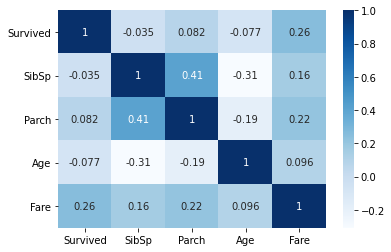

In [19]:
matrix = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), cmap = "Blues", annot=True)

The only numerical feature that strongly correlates with Survived is Fare. This might be explaind by the fact that the cabins of the richer passengers are generally located in the upper parts of the boat, which was not directly fluted after the Titanic hit the iceberg. Moreover, the richer passengers were first to go on the life boats.

This does not nessecarily mean that the other features are not relevant. For instance, although Age in general only shows a rather weak correlation with Survived, we should have a closer look at the children, which were usually the ones to be allowed to go on the life boats first. Same for women, so the feature Sex might be important as well.

So let's have a closer look a the individual features in order to learn more about their importance.

Binning Age attribute

In [20]:
def bin_age(Age) :
    if Age <= 1:
        age = 'infant'
    elif Age <= 4: 
        age = 'toddler'
    elif Age <= 13:
        age = 'child'
    elif Age <= 18:
        age = 'teenager'
    elif Age <= 35:
        age = 'Young_Adult'
    elif Age <= 45:
        age = 'adult'
    elif Age <= 55:
        age = 'middle_aged'
    elif Age <= 65:
        age = 'senior_citizen'
    else:
        age = 'old'
    return (age)

In [21]:
train['age'] = train['Age'].apply(lambda x: bin_age(x))
test['age'] = test['Age'].apply(lambda x: bin_age(x))

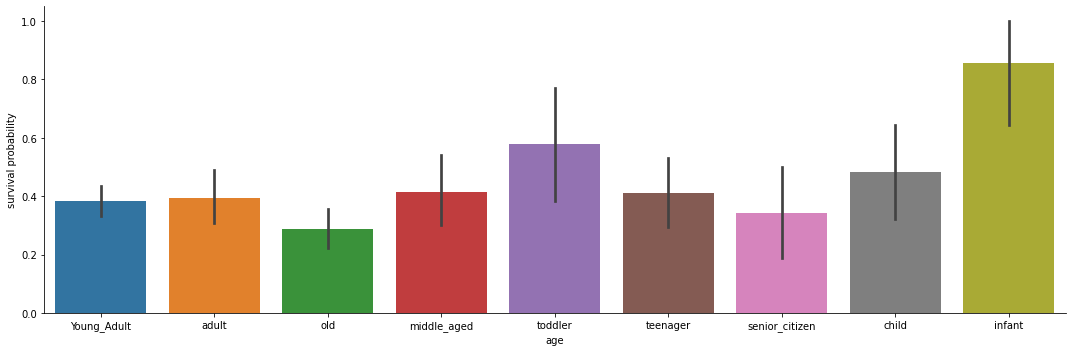

In [22]:
# plot age vs survival probability
plot = sns.catplot(x="age", y="Survived", kind="bar", data=train,aspect=3).set_ylabels("survival probability")

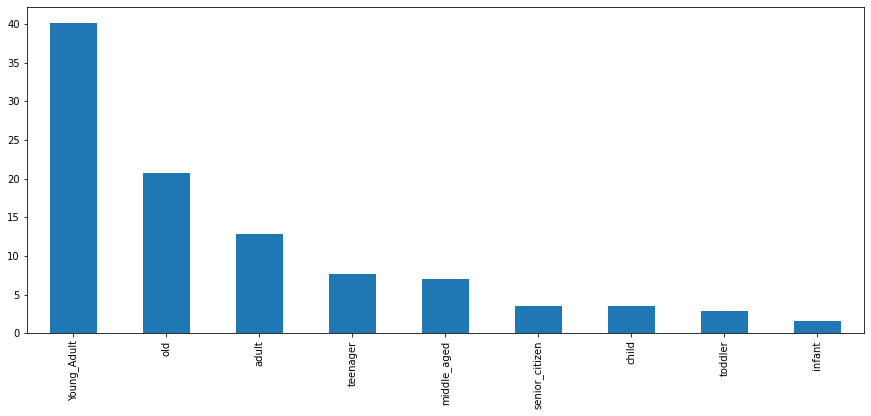

In [23]:
(train.age.value_counts(normalize = True)*100).plot(kind = 'bar', figsize = (15,6))

There are more young adults and few infants and toddlers amongst the passengers.

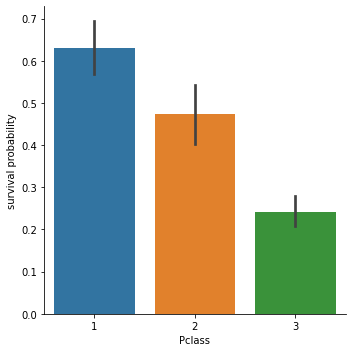

In [24]:
# plot Pclass vs survival probability
plot = sns.catplot(x="Pclass", y="Survived", kind="bar", data=train).set_ylabels("survival probability")

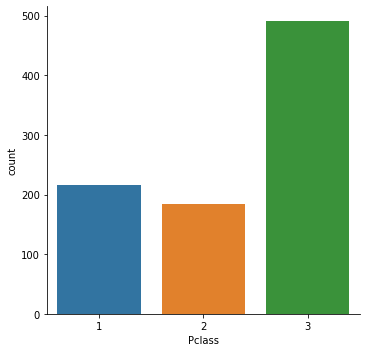

In [25]:
# Number of passengers per passenger class
plot = sns.catplot(x="Pclass", kind="count", data=train)

In the third class there are twice as much passengers than in the first and second class, respectively.

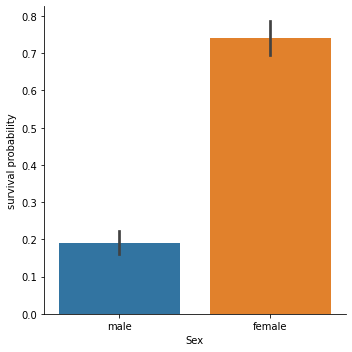

In [26]:
# Number of female and male passengers per passenger class
plot = sns.catplot(x="Sex", y="Survived", kind="bar", data=train).set_ylabels("survival probability")

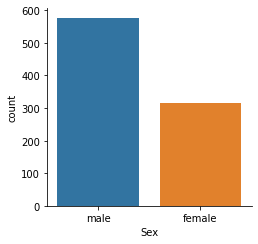

In [27]:
# Number of female and male passengers per passenger class
plot = sns.catplot(x="Sex", kind="count", data=train, height=3.5)

There are twice as much male passengers on the board as they are female passengers.

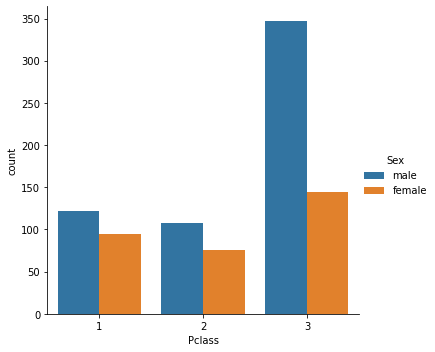

In [28]:
# Number of female and male passengers per passenger class
plot = sns.catplot(x="Pclass", hue="Sex", kind="count", data=train)

It is remarkable that the percentage of men in the third class is much bigger.

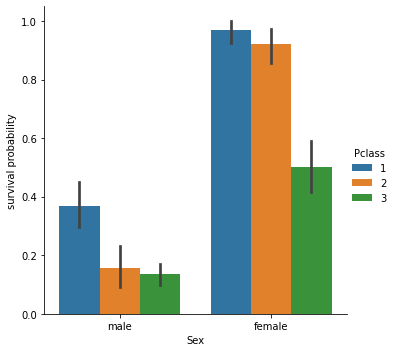

In [29]:
plot = sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=train).set_ylabels("survival probability")

The survival probability for a man from the first class is twice as high than for a man from the second or third class. Regarding women, about 90 % of the women from the first and the second class survive, in contrast to only about 50% of the women in the third class.

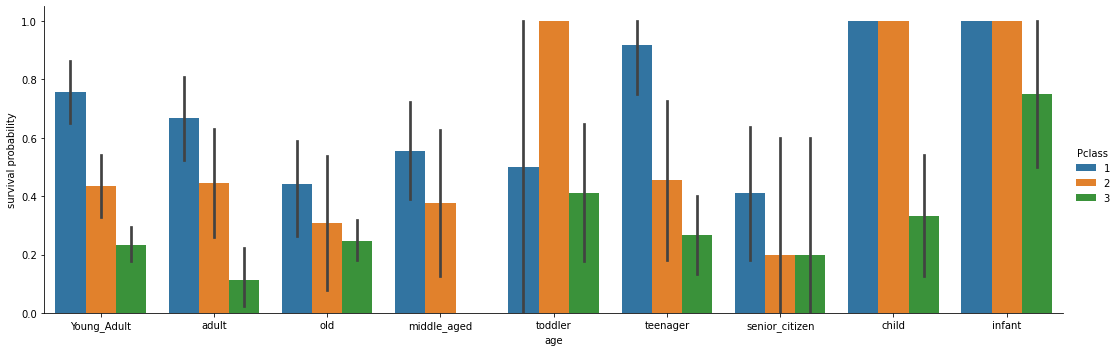

In [30]:
# plot survival probability of cildren and adults regarding the different classes
plot = sns.catplot(x="age", y="Survived", hue="Pclass", kind="bar", data=train,aspect=3).set_ylabels("survival probability")

Infants from class1 and class2 survived almost 100 percent, where as only 80 percent of the infants from class3 survived. 
children from class1 and class2 survived almost 100 percent, where as only 35 percent of the children from class3 survived.
Toddlers from class2 survived almost 100 percent, where as only 50 percent of class1 and 40 percent of class3 todlers survived.

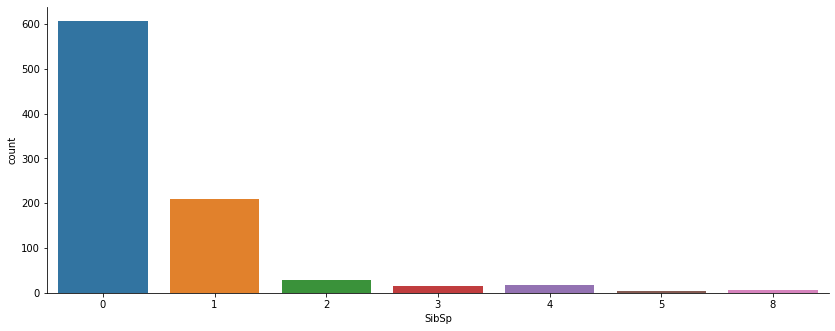

In [31]:
# Number of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp",kind="count", data=train, height=4.7, aspect=2.45)

Most passengers travel as singles.

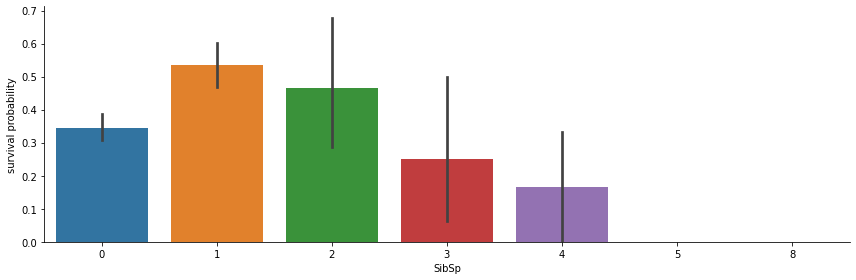

In [32]:
# Survival probability of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp", y="Survived", kind="bar", data=train, height=4, aspect=3).set_ylabels("survival probability")

The survival chance of a passenger with 1 or 2 siblings/spouses is significantly higher than than for a single passenger or a passenger with 3 or more siblings/spouses.

Let's analyse the data by splitting it between different age groups since most of the adults might usually be married.

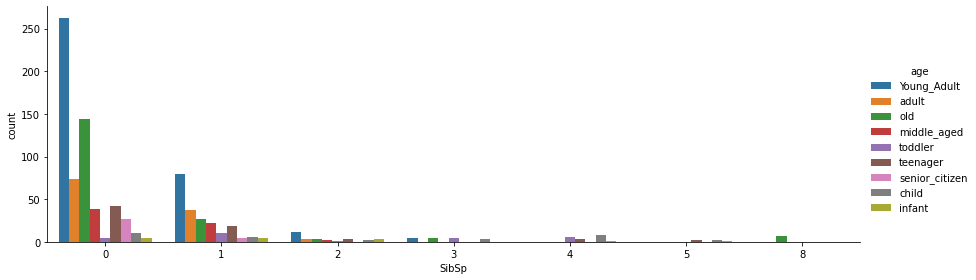

In [33]:
# Number of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp", hue='age',kind="count", data=train, height=4, aspect=3)

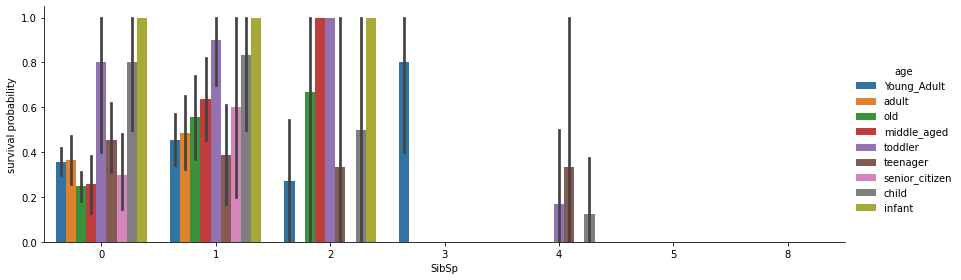

In [34]:
# Survival probability of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp", y="Survived", hue="age", kind="bar", data=train, height=4, aspect=3).set_ylabels("survival probability")

The survival chance of an child with 2 or less siblings is much higher than than for a child with 3 or more siblings. 
On the contrary, for an adult with 2 or less siblings the survival chance is lower than for an adult with 3 siblings. 
Hence, the family size seems to play an important role, too. To confirm this, we first have to analize Parch, aswell.

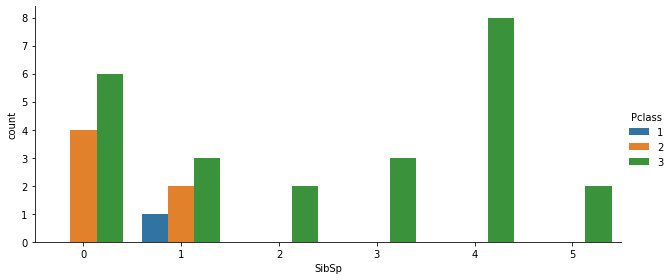

In [35]:
# Number of children with no or several siblings per class (assuming children younger than 15 are not married)
plot = sns.catplot(x="SibSp", hue='Pclass', kind="count", data=train[train['age']=='child'], height=4, aspect=2.15)

Obviously, the children in the third class have more siblings and hence the families are bigger (also see analysis of Parch)

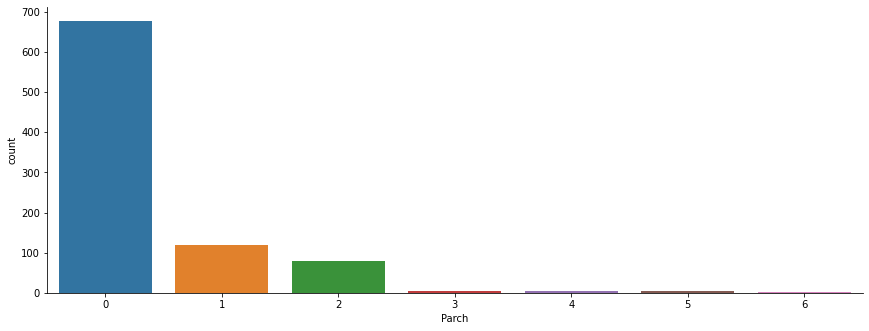

In [36]:
# Number of passengers with no or several parents/children
plot = sns.catplot(x="Parch",kind="count", data=train, height=4.7, aspect=2.55)

Most passengers have neither children nor parents on board.

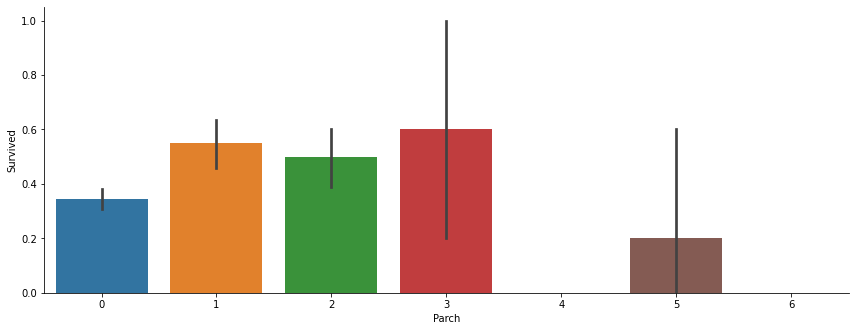

In [37]:
# Survival chance of passengers with no or several parents/children
plot = sns.catplot(x="Parch", y='Survived',kind="bar", data=train, height=4.7, aspect=2.55)

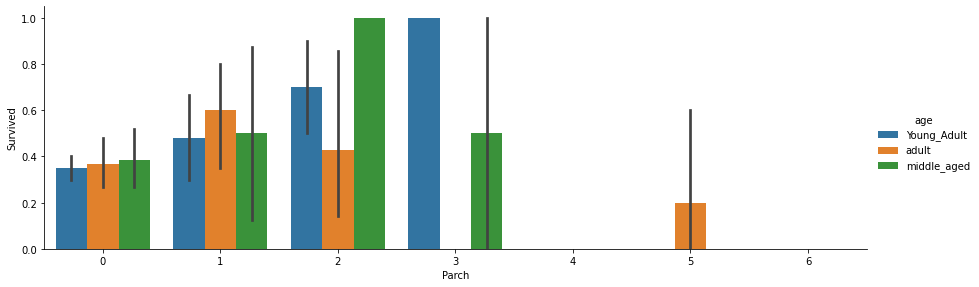

In [38]:
# Survival chance of children/adults with no or several parents/children
plot = sns.catplot(x="Parch", y='Survived', hue='age',kind="bar", data=train[train['age'].isin(['Young_Adult','adult','middle_aged'])], height=4.1, aspect=3)

Passengers having 2,3 children have more surival rates than with less than 2 children and more than 3 children.

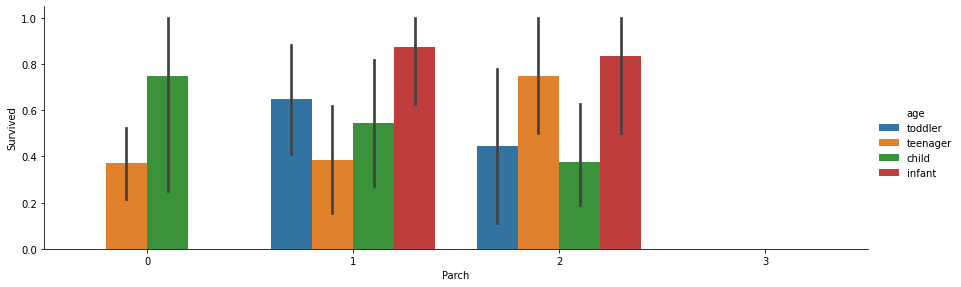

In [39]:
# Survival chance of children/adults with no or several parents/children
plot = sns.catplot(x="Parch", y='Survived', hue='age',kind="bar", data=train[train['age'].isin(['infant','toddler','child','teenager'])], height=4.1, aspect=3)

Passengers having 1,2 parents have more surival rates than those with no parents on board.

The titanic had three different stops before it went on to cross the Atlantic - Southhampton (England), Cherbourg (France), and Queenstown (Ireland).

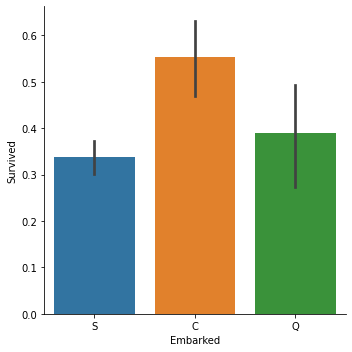

In [40]:
# Survival Probability of passengers emarked a the three different habours
plot = sns.catplot(x="Embarked", y='Survived', kind="bar", data=train, height=5, aspect=1)

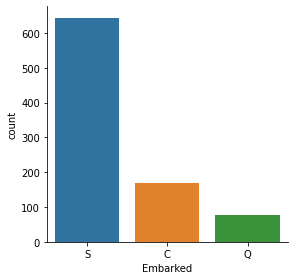

In [41]:
# Number of passengers that embarked a the three different habours
plot = sns.catplot(x="Embarked",kind="count", data=train, height=4, aspect=1)

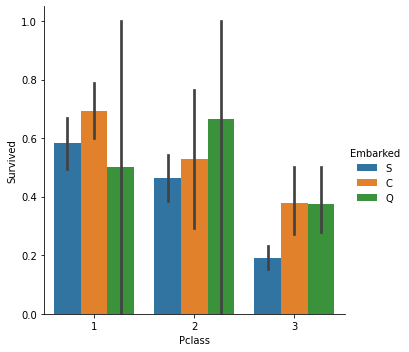

In [42]:
# Survival Probability of passengers emarked a the three different habours per class
plot = sns.catplot(x="Pclass", y='Survived', hue='Embarked', kind="bar", data=train, height=5, aspect=1)

Passengers embarked at Southhampton (England)have less survival rates than those embarked at Cherbourg (France), and Queenstown (Ireland).

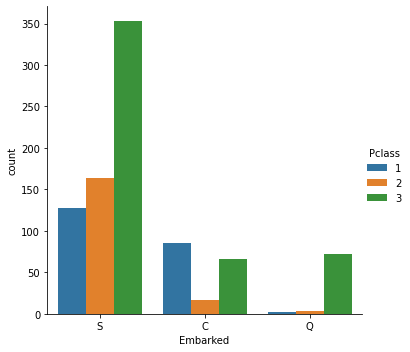

In [43]:
# Number of passengers emarked a the three different habours per class
plot = sns.catplot(x="Embarked", hue='Pclass',kind="count", data=train, height=5, aspect=1)

Function to drop unimportant columns

In [44]:
def drop_unimp_cols(data,unimp_cols) :
    print("Deleting unimportant columns", unimp_cols)
    data.drop(unimp_cols,axis=1,inplace=True)

In [45]:
drop_unimp_cols(train,['Age'])
drop_unimp_cols(test,['Age'])

Deleting unimportant columns ['Age']
Deleting unimportant columns ['Age']


In [46]:
PassengerId=test.PassengerId
drop_unimp_cols(train,['PassengerId'])
drop_unimp_cols(test,['PassengerId'])

Deleting unimportant columns ['PassengerId']
Deleting unimportant columns ['PassengerId']


Handling Null Values

In [47]:
num_cols=train.select_dtypes(include=['int64','float64']).columns
cat_cols=train.select_dtypes(exclude=['int64','float64']).columns
num_cols=num_cols.drop(['Survived'])
print(num_cols);print(cat_cols)

Index(['Pclass', 'SibSp', 'Parch', 'Fare'], dtype='object')
Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'age'], dtype='object')


In [48]:
from sklearn.impute import SimpleImputer
num_imputer=SimpleImputer()
cat_imputer=SimpleImputer(strategy='most_frequent')
num_imputer.fit(train[num_cols])
cat_imputer.fit(train[cat_cols])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [49]:
train[num_cols]=num_imputer.transform(train[num_cols])
test[num_cols]=num_imputer.transform(test[num_cols])
train[cat_cols]=cat_imputer.transform(train[cat_cols])
test[cat_cols]=cat_imputer.transform(test[cat_cols])

In [50]:
total_NAs(train)

Total NAs: 0


In [51]:
total_NAs(test)

Total NAs: 0


Feature Engineering

In [52]:
train['Name'][240:280]

240                            Zabour, Miss. Thamine
241                   Murphy, Miss. Katherine "Kate"
242                  Coleridge, Mr. Reginald Charles
243                    Maenpaa, Mr. Matti Alexanteri
244                             Attalah, Mr. Sleiman
245                      Minahan, Dr. William Edward
246            Lindahl, Miss. Agda Thorilda Viktoria
247                  Hamalainen, Mrs. William (Anna)
248                    Beckwith, Mr. Richard Leonard
249                    Carter, Rev. Ernest Courtenay
250                           Reed, Mr. James George
251       Strom, Mrs. Wilhelm (Elna Matilda Persson)
252                        Stead, Mr. William Thomas
253                         Lobb, Mr. William Arthur
254         Rosblom, Mrs. Viktor (Helena Wilhelmina)
255          Touma, Mrs. Darwis (Hanne Youssef Razi)
256                   Thorne, Mrs. Gertrude Maybelle
257                             Cherry, Miss. Gladys
258                                 Ward, Miss

The passengers have different titels which give information about their sex (Mr., Mrs., Miss., Master, Rev.), about their social status (Dr., Rev.) or about their age (Mrs., Miss., Master, Dr., Rev.). Characteristics which affect the survival probability. Hence, it makes sense to create a new feature Title.

In [53]:
# extracting the Title (which always ends with a ".")
for name_string in train['Name']:
    train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.', expand=True)

#transform titles which are synonyms
train['Title']=train['Title'].replace({'Ms':'Miss','Mlle':'Miss','Mme':'Mrs'})

train['Title'].value_counts()

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Col           2
Major         2
Capt          1
Don           1
Lady          1
Jonkheer      1
Countess      1
Sir           1
Name: Title, dtype: int64

In [54]:
# extracting the Title (which always ends with a ".")
for name_string in test['Name']:
    test['Title'] = test['Name'].str.extract('([A-Za-z]+)\.', expand=True)

#transform titles which are synonyms
test['Title']=test['Title'].replace({'Ms':'Miss','Mlle':'Miss','Mme':'Mrs'})

test['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Name: Title, dtype: int64

The analysis reveals some more titles, some of which are noble titles or indicate a higher social standing. We now can summarize the different titles in the following categories:

In [55]:
# Noble passengers
train['Title']=train['Title'].replace(['Sir','Don','Dona','Jonkheer','Lady','Countess'], 'Noble')

# passengers with a higher social standing
train['Title']=train['Title'].replace(['Dr', 'Rev','Col','Major','Capt'], 'Others')

train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Others     18
Noble       5
Name: Title, dtype: int64

In [56]:
# Noble passengers
test['Title']=test['Title'].replace(['Sir','Don','Dona','Jonkheer','Lady','Countess'], 'Noble')

# passengers with a higher social standing
test['Title']=test['Title'].replace(['Dr', 'Rev','Col','Major','Capt'], 'Others')

test['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Others      5
Noble       1
Name: Title, dtype: int64

In [57]:
drop_unimp_cols(train,['Name'])
drop_unimp_cols(test,['Name'])

Deleting unimportant columns ['Name']
Deleting unimportant columns ['Name']


Create FamilySize Feature

In [58]:
# create feature FamilySize
train.loc[train['SibSp'] + train['Parch'] + 1 == 1, 'FamilySize'] = 'Single'
train.loc[train['SibSp'] + train['Parch'] + 1 > 1 , 'FamilySize'] = 'Small'
train.loc[train['SibSp'] + train['Parch'] + 1 > 4 , 'FamilySize'] = 'Big'

# create feature FamilySize
test.loc[test['SibSp'] + test['Parch'] + 1 == 1, 'FamilySize'] = 'Single'
test.loc[test['SibSp'] + test['Parch'] + 1 > 1 , 'FamilySize'] = 'Small'
test.loc[test['SibSp'] + test['Parch'] + 1 > 4 , 'FamilySize'] = 'Big'

In [59]:
# size of each category
print("\n train \n")
print(train.FamilySize.value_counts())
print("\n test \n")
print(test.FamilySize.value_counts())


 train 

Single    537
Small     292
Big        62
Name: FamilySize, dtype: int64

 test 

Single    253
Small     145
Big        20
Name: FamilySize, dtype: int64


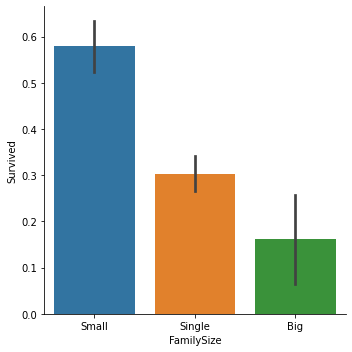

In [60]:
plot = sns.catplot(x='FamilySize', y='Survived', kind='bar', data=train)

Train Validation Split

In [61]:
train_x=train
train_y=pd.DataFrame(train['Survived'])
print(train_x.columns);print(train_y.columns)

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'age', 'Title', 'FamilySize'],
      dtype='object')
Index(['Survived'], dtype='object')


In [62]:
from sklearn.model_selection import train_test_split
train_x,val_x,train_y,val_y=train_test_split(train_x,train_y,test_size=0.2,random_state=42)
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(712, 12)
(179, 12)
(712, 1)
(179, 1)


Datatypes Correction

In [63]:
# Function to convert all object columns to categorical
def convert_obj_categ(data) :
    categ_cols=data.select_dtypes(include='object').columns
    for i in categ_cols :
        data[categ_cols]=data[categ_cols].astype('str').astype('category')
    print (data.select_dtypes(include='category').columns, "columns are converted to categorical")

In [64]:
convert_obj_categ(train_x)
convert_obj_categ(val_x)
convert_obj_categ(test)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Index(['Sex', 'Ticket', 'Cabin', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object') columns are converted to categorical
Index(['Sex', 'Ticket', 'Cabin', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object') columns are converted to categorical
Index(['Sex', 'Ticket', 'Cabin', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object') columns are converted to categorical


In [65]:
train_x.Cabin=train_x.Cabin.astype('str')
val_x.Cabin=val_x.Cabin.astype('str')
test.Cabin=test.Cabin.astype('str')

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [66]:
train_x.Cabin.str[0].value_counts()

B    591
C     52
E     24
D     19
F     12
A     10
G      3
T      1
Name: Cabin, dtype: int64

In [67]:
train_x['cabin']=train_x['Cabin'].str[0]
val_x['cabin']=val_x['Cabin'].str[0]
test['cabin']=test['Cabin'].str[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
drop_unimp_cols(train_x,'Cabin')
drop_unimp_cols(val_x,'Cabin')
drop_unimp_cols(test,'Cabin')

Deleting unimportant columns Cabin
Deleting unimportant columns Cabin
Deleting unimportant columns Cabin


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [69]:
# Function to convert necessary (non-object) columns to categorical
def convert_other_categ(data,other_categ_cols) :
    for i in other_categ_cols :
        data[other_categ_cols]=data[other_categ_cols].astype('str').astype('category')
    print (data.select_dtypes(include='category').columns, "columns are converted to categorical")

In [70]:
convert_other_categ(train_x,['Pclass'])
convert_other_categ(val_x,['Pclass'])
convert_other_categ(test,['Pclass'])

Index(['Pclass', 'Sex', 'Ticket', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object') columns are converted to categorical
Index(['Pclass', 'Sex', 'Ticket', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object') columns are converted to categorical
Index(['Pclass', 'Sex', 'Ticket', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object') columns are converted to categorical


In [71]:
print(train_x.Ticket.nunique())
print(train_x.shape[0])
print(val_x.Ticket.nunique())
print(val_x.shape[0])
print(test.Ticket.nunique())
print(test.shape[0])

558
712
169
179
363
418


In [72]:
drop_unimp_cols(train_x,['Ticket'])
drop_unimp_cols(val_x,['Ticket'])
drop_unimp_cols(test,['Ticket'])

Deleting unimportant columns ['Ticket']
Deleting unimportant columns ['Ticket']
Deleting unimportant columns ['Ticket']


In [73]:
def get_value_counts(variable) :
    print(len(train_x[variable].value_counts()))
    print(len(val_x[variable].value_counts()))
    print(len(test[variable].value_counts()))
    print(train_x[variable].value_counts())
    print(val_x[variable].value_counts())
    print(test[variable].value_counts())

Categorical Encoding

In [74]:
get_value_counts('Parch')

7
6
8
0.0    541
1.0     94
2.0     67
5.0      3
3.0      3
4.0      3
6.0      1
Name: Parch, dtype: int64
0.0    137
1.0     24
2.0     13
5.0      2
3.0      2
4.0      1
Name: Parch, dtype: int64
0.0    324
1.0     52
2.0     33
3.0      3
9.0      2
4.0      2
5.0      1
6.0      1
Name: Parch, dtype: int64


Mean Encoding Parch

In [75]:
train_x.groupby(['Parch'])['Survived'].mean()

Parch
0.0    0.338262
1.0    0.531915
2.0    0.477612
3.0    1.000000
4.0    0.000000
5.0    0.000000
6.0    0.000000
Name: Survived, dtype: float64

In [76]:
parch_ordered_labels = train_x.groupby(['Parch'])['Survived'].mean().to_dict()
parch_ordered_labels

{0.0: 0.33826247689463956,
 1.0: 0.5319148936170213,
 2.0: 0.47761194029850745,
 3.0: 1.0,
 4.0: 0.0,
 5.0: 0.0,
 6.0: 0.0}

In [77]:
train_x['parch_ordered'] = train_x.Parch.map(parch_ordered_labels)
val_x['parch_ordered'] = val_x.Parch.map(parch_ordered_labels)
test['parch_ordered'] = test.Parch.map(parch_ordered_labels)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
drop_unimp_cols(train_x,['Parch'])
drop_unimp_cols(val_x,['Parch'])
drop_unimp_cols(test,['Parch'])

Deleting unimportant columns ['Parch']
Deleting unimportant columns ['Parch']
Deleting unimportant columns ['Parch']


In [79]:
val_x.isna().sum()

Survived         0
Pclass           0
Sex              0
SibSp            0
Fare             0
Embarked         0
age              0
Title            0
FamilySize       0
cabin            0
parch_ordered    0
dtype: int64

In [80]:
test.isna().sum()

Pclass           0
Sex              0
SibSp            0
Fare             0
Embarked         0
age              0
Title            0
FamilySize       0
cabin            0
parch_ordered    2
dtype: int64

In [81]:
test.parch_ordered=test.parch_ordered.fillna(0.000000)

In [82]:
total_NAs(test)

Total NAs: 0


In [83]:
train_x.select_dtypes(include='category').columns

Index(['Pclass', 'Sex', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object')

In [84]:
get_value_counts('Pclass')

3
3
3
3.0    398
1.0    163
2.0    151
Name: Pclass, dtype: int64
3.0    93
1.0    53
2.0    33
Name: Pclass, dtype: int64
3.0    218
1.0    107
2.0     93
Name: Pclass, dtype: int64


Target guided ordinal Encoding Pclass

In [85]:
train_x.groupby(['Pclass'])['Survived'].mean().sort_values()

Pclass
3.0    0.241206
2.0    0.483444
1.0    0.607362
Name: Survived, dtype: float64

In [86]:
Pclass_ordered_labels = train_x.groupby(['Pclass'])['Survived'].mean().sort_values().index
Pclass_ordered_labels

CategoricalIndex(['3.0', '2.0', '1.0'], categories=['1.0', '2.0', '3.0'], ordered=False, name='Pclass', dtype='category')

In [87]:
Pclass_ordinal_label = {k:i for i, k in enumerate(Pclass_ordered_labels, 0)} 
Pclass_ordinal_label

{'3.0': 0, '2.0': 1, '1.0': 2}

In [88]:
train_x['Pclass_ordered'] = train_x.Pclass.map(Pclass_ordinal_label)
val_x['Pclass_ordered'] = val_x.Pclass.map(Pclass_ordinal_label)
test['Pclass_ordered'] = test.Pclass.map(Pclass_ordinal_label)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
drop_unimp_cols(train_x,['Pclass'])
drop_unimp_cols(val_x,['Pclass'])
drop_unimp_cols(test,['Pclass'])

Deleting unimportant columns ['Pclass']
Deleting unimportant columns ['Pclass']
Deleting unimportant columns ['Pclass']


In [90]:
train_x.Pclass_ordered=train_x.Pclass_ordered.astype('str').astype('int8')
val_x.Pclass_ordered=val_x.Pclass_ordered.astype('str').astype('int8')
test.Pclass_ordered=test.Pclass_ordered.astype('str').astype('int8')

Mean Encoding for SibSp

In [91]:
train_x.groupby(['SibSp'])['Survived'].mean()

SibSp
0.0    0.345041
1.0    0.506098
2.0    0.478261
3.0    0.307692
4.0    0.187500
5.0    0.000000
8.0    0.000000
Name: Survived, dtype: float64

In [92]:
sibsp_ordered_labels = train_x.groupby(['SibSp'])['Survived'].mean().to_dict()
sibsp_ordered_labels

{0.0: 0.3450413223140496,
 1.0: 0.5060975609756098,
 2.0: 0.4782608695652174,
 3.0: 0.3076923076923077,
 4.0: 0.1875,
 5.0: 0.0,
 8.0: 0.0}

In [93]:
train_x['sibsp_ordered'] = train_x.SibSp.map(sibsp_ordered_labels)
val_x['sibsp_ordered'] = val_x.SibSp.map(sibsp_ordered_labels)
test['sibsp_ordered'] = test.SibSp.map(sibsp_ordered_labels)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
drop_unimp_cols(train_x,['SibSp'])
drop_unimp_cols(val_x,['SibSp'])
drop_unimp_cols(test,['SibSp'])

Deleting unimportant columns ['SibSp']
Deleting unimportant columns ['SibSp']
Deleting unimportant columns ['SibSp']


In [95]:
get_value_counts('Sex')

2
2
2
male      467
female    245
Name: Sex, dtype: int64
male      110
female     69
Name: Sex, dtype: int64
male      266
female    152
Name: Sex, dtype: int64


In [96]:
get_value_counts('Embarked')

3
3
3
S    527
C    125
Q     60
Name: Embarked, dtype: int64
S    119
C     43
Q     17
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


In [97]:
get_value_counts('age')

9
9
9
Young_Adult       293
old               145
adult              85
middle_aged        54
teenager           52
toddler            24
senior_citizen     24
child              22
infant             13
Name: age, dtype: int64
Young_Adult       65
old               40
adult             29
teenager          16
middle_aged        9
child              9
senior_citizen     8
toddler            2
infant             1
Name: age, dtype: int64
Young_Adult       173
old                88
adult              53
middle_aged        33
teenager           26
senior_citizen     17
child              17
infant              8
toddler             3
Name: age, dtype: int64


In [98]:
get_value_counts('Title')

6
6
6
Mr        419
Miss      146
Mrs        97
Master     33
Others     15
Noble       2
Name: Title, dtype: int64
Mr        98
Miss      39
Mrs       29
Master     7
Others     3
Noble      3
Name: Title, dtype: int64
Mr        240
Miss       79
Mrs        72
Master     21
Others      5
Noble       1
Name: Title, dtype: int64


In [99]:
get_value_counts('FamilySize')

3
3
3
Single    429
Small     232
Big        51
Name: FamilySize, dtype: int64
Single    108
Small      60
Big        11
Name: FamilySize, dtype: int64
Single    253
Small     145
Big        20
Name: FamilySize, dtype: int64


In [100]:
get_value_counts('cabin')

8
7
7
B    591
C     52
E     24
D     19
F     12
A     10
G      3
T      1
Name: cabin, dtype: int64
B    143
D     14
E      8
C      7
A      5
F      1
G      1
Name: cabin, dtype: int64
B    345
C     35
D     13
E      9
F      8
A      7
G      1
Name: cabin, dtype: int64


Mean Encoding Cabin

In [101]:
train_x.groupby(['cabin'])['Survived'].mean()

cabin
A    0.400000
B    0.326565
C    0.596154
D    0.736842
E    0.750000
F    0.583333
G    0.333333
T    0.000000
Name: Survived, dtype: float64

In [102]:
cabin_ordered_labels = train_x.groupby(['cabin'])['Survived'].mean().to_dict()
cabin_ordered_labels

{'A': 0.4,
 'B': 0.32656514382402707,
 'C': 0.5961538461538461,
 'D': 0.7368421052631579,
 'E': 0.75,
 'F': 0.5833333333333334,
 'G': 0.3333333333333333,
 'T': 0.0}

In [103]:
train_x['cabin_ordered'] = train_x.cabin.map(cabin_ordered_labels)
val_x['cabin_ordered'] = val_x.cabin.map(cabin_ordered_labels)
test['cabin_ordered'] = test.cabin.map(cabin_ordered_labels)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [104]:
drop_unimp_cols(train_x,['cabin'])
drop_unimp_cols(val_x,['cabin'])
drop_unimp_cols(test,['cabin'])

Deleting unimportant columns ['cabin']
Deleting unimportant columns ['cabin']
Deleting unimportant columns ['cabin']


In [105]:
test.isna().sum()

Sex               0
Fare              0
Embarked          0
age               0
Title             0
FamilySize        0
parch_ordered     0
Pclass_ordered    0
sibsp_ordered     0
cabin_ordered     0
dtype: int64

In [106]:
print("======verify that the no of columns are the same in train,val and test before dummification======")
print(train_x.shape[1])
print(val_x.shape[1])
print(test.shape[1])

======verify that the no of columns are the same in train,val and test before dummification======
11
11
10


In [107]:
cat_cols=train_x.select_dtypes(include='category').columns
cat_cols

Index(['Sex', 'Embarked', 'age', 'Title', 'FamilySize'], dtype='object')

In [108]:
train_x=pd.get_dummies(train_x,cat_cols,drop_first=True)
val_x=pd.get_dummies(val_x,cat_cols,drop_first=True)
test=pd.get_dummies(test,cat_cols,drop_first=True)

In [109]:
train_x.drop(['Survived'],axis=1,inplace=True)
val_x.drop(['Survived'],axis=1,inplace=True)

In [110]:
print("======verify that the no of columns are the same in train,val and test after dummification======")
print(train_x.shape[1])
print(val_x.shape[1])
print(test.shape[1])

======verify that the no of columns are the same in train,val and test after dummification======
23
23
23


Standardizing numerical columns

In [111]:
num_cols=train_x.select_dtypes(include=['int8','float64']).columns
print(num_cols)

Index(['Fare', 'parch_ordered', 'Pclass_ordered', 'sibsp_ordered',
       'cabin_ordered'],
      dtype='object')


In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_x[num_cols])
train_x[num_cols] =scaler.transform(train_x[num_cols])
val_x[num_cols] =scaler.transform(val_x[num_cols])
test[num_cols] =scaler.transform(test[num_cols])

Text(0.5, 1.0, 'Class imbalance in the train data')

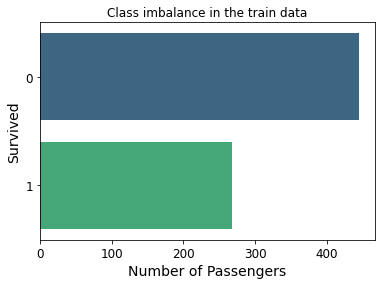

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plot to Showcase the Class imbalance for Survived(Yes/No)
sns.countplot(y=train_y['Survived'],palette='viridis')
plt.xlabel('Number of Passengers')
plt.title('Class imbalance in the train data')

Model Building

In [114]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

# Build the model
reg1 = LogisticRegressionCV()

# Fit the data on train
reg1.fit(train_x, train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [115]:
# Predict on train and val
train_pred1 = reg1.predict(train_x)
val_pred1 = reg1.predict(val_x)

In [116]:
# Model evaluation
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_curve,confusion_matrix
confusion_matrix_train1 = confusion_matrix(train_y, train_pred1)
confusion_matrix_val1 = confusion_matrix(val_y, val_pred1)

Text(0.5, 1.0, 'Logistic Regression Accuracy Score Train: 0.8469101123595506')

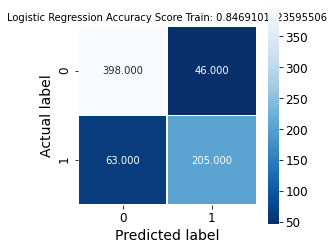

In [117]:
# Confusion matrix for Logistic Regression Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred1)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Logistic Regression Accuracy Score Val: 0.8212290502793296')

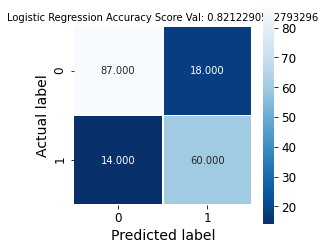

In [118]:
# Confusion matrix for Logistic Regression Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred1)))
plt.title(all_sample_title, size = 10)

In [119]:
print("Train Accuracy",accuracy_score(train_y,train_pred1))
print("Train Recall",recall_score(train_y, train_pred1, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred1,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred1))
print("Val Recall",recall_score(val_y, val_pred1, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred1,pos_label=0))

Train Accuracy 0.8469101123595506
Train Recall 0.7649253731343284
Train Specificity 0.8963963963963963
Val Accuracy 0.8212290502793296
Val Recall 0.8108108108108109
Val Specificity 0.8285714285714286


In [120]:
def draw_roc_curve(X, y, model):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    probs = model.predict_proba(X)
    probs = probs[:, 1]
    auc = roc_auc_score(y, probs)
    # calculate AUC
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for Logistic Regression')
    plt.show()

AUC: 0.884


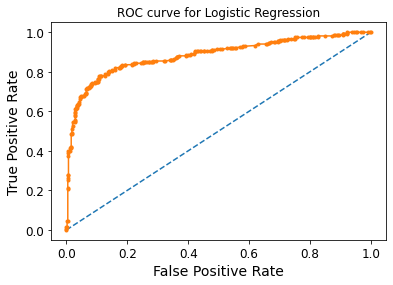

In [121]:
draw_roc_curve(train_x, train_y,reg1)

In [122]:
from sklearn.model_selection import GridSearchCV

reg_grid = LogisticRegression(random_state=100)
reg_param_grid = {'penalty':['l1', 'l2'],'C':[0.01, 0.1, 1, 10, 100]}
reg2 = GridSearchCV(reg_grid,param_grid=reg_param_grid,cv=3)
%time reg2.fit(train_x,train_y)
print(reg2.best_estimator_)
print(reg2.best_score_)
print(reg2.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

CPU times: user 1.4 s, sys: 1.36 s, total: 2.75 s
Wall time: 713 ms
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.8258459501944238
{'C': 1, 'penalty': 'l2'}


In [123]:
# Predict on train and val
train_pred2 = reg2.predict(train_x)
val_pred2 = reg2.predict(val_x)

In [124]:
# Model evaluation
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_curve,confusion_matrix
confusion_matrix_train2 = confusion_matrix(train_y, train_pred2)
confusion_matrix_val2 = confusion_matrix(val_y, val_pred2)

Text(0.5, 1.0, 'Logistic Regression with CV Accuracy Score Train: 0.8426966292134831')

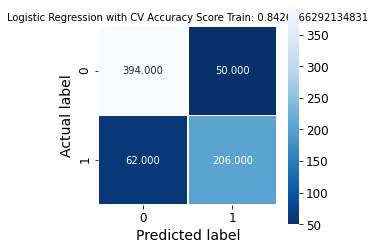

In [125]:
# Confusion matrix for Logistic Regression with CV Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression with CV Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred2)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Logistic Regression Accuracy Score Val: 0.8212290502793296')

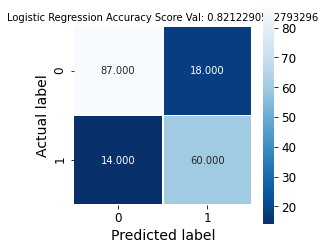

In [126]:
# Confusion matrix for Logistic Regression with CV Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred2)))
plt.title(all_sample_title, size = 10)

In [127]:
print("Train Accuracy",accuracy_score(train_y,train_pred2))
print("Train Recall",recall_score(train_y, train_pred2, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred2,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred2))
print("Val Recall",recall_score(val_y, val_pred2, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred2,pos_label=0))

Train Accuracy 0.8426966292134831
Train Recall 0.7686567164179104
Train Specificity 0.8873873873873874
Val Accuracy 0.8212290502793296
Val Recall 0.8108108108108109
Val Specificity 0.8285714285714286


AUC: 0.882


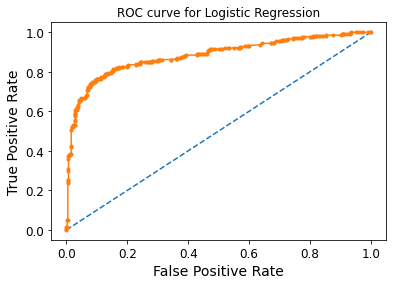

In [128]:
draw_roc_curve(train_x, train_y,reg2)

Decision Tree

In [129]:
from sklearn.tree import DecisionTreeClassifier
clf1=DecisionTreeClassifier(random_state=1,class_weight='balanced',max_depth=4)
#Fit the data on train
%time clf1.fit(train_x, train_y)

CPU times: user 8.27 ms, sys: 1.08 ms, total: 9.35 ms
Wall time: 9.29 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [130]:
# Predict
train_pred3 = clf1.predict(train_x)
val_pred3 = clf1.predict(val_x)

In [131]:
# Model evaluation
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_curve,confusion_matrix
confusion_matrix_train3 = confusion_matrix(train_y, train_pred3)
confusion_matrix_val3 = confusion_matrix(val_y, val_pred3)

Text(0.5, 1.0, 'Weight Balanced DT Recall Score Train: 0.8441011235955056')

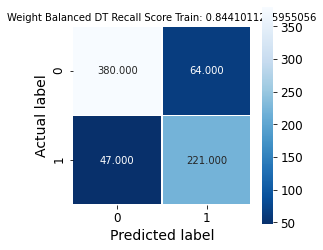

In [132]:
# Confusion matrix for Weight Balanced DT Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Weight Balanced DT Recall Score Train: {}'.format((accuracy_score(train_y, train_pred3)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Weight Balanced DT Recall Score Val: 0.8212290502793296')

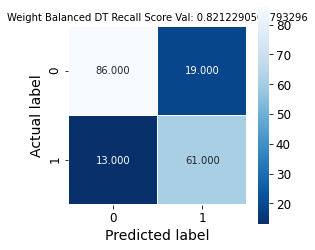

In [133]:
# Confusion matrix for Weight Balanced DT Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Weight Balanced DT Recall Score Val: {}'.format((accuracy_score(val_y, val_pred3)))
plt.title(all_sample_title, size = 10)

In [134]:
print("Train Accuracy",accuracy_score(train_y,train_pred3))
print("Train Recall",recall_score(train_y,train_pred3, pos_label=1))
print("Train Specificity",recall_score(train_y,train_pred3,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred3))
print("Val Recall",recall_score(val_y, val_pred3, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred3,pos_label=0))

Train Accuracy 0.8441011235955056
Train Recall 0.8246268656716418
Train Specificity 0.8558558558558559
Val Accuracy 0.8212290502793296
Val Recall 0.8243243243243243
Val Specificity 0.819047619047619


AUC: 0.895


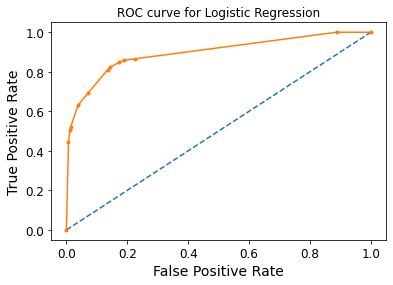

In [135]:
draw_roc_curve(train_x, train_y,clf1)

In [136]:
# Get the information of important variables that can help accurate classify the customers as to who are likely to exit and 
# who are not.
importances=clf1.feature_importances_
print(importances)
print(train_x.columns)
# numpy.argsort() is used to perform a sort on input array and returns an array of indices. when the kind keyword is specified 
# an indirect sort along the given axis using the algorithm specified by the kind keyword is performed.
# syntax: numpy.argsort(arr, axis=-1, kind=’quicksort’, order=None) Here ::-1 sorts in descending order of importance.
indices = np.argsort(importances)[::-1]
print(indices) # Prints original column indexes in sorted descending order of importance.
names=np.asarray(train_x.columns[indices])
print(names) # Gives an ndarray of variables in the order of importance
Important=pd.DataFrame(np.sort(importances)[::-1],index=names,columns=['Imp'])
print(Important) # Gives a DF of variables as index and their respective importance as column in the desc order of importance.

[0.16968702 0.00523979 0.10734634 0.00935841 0.05154532 0.
 0.         0.00893264 0.         0.         0.         0.
 0.         0.00703326 0.         0.         0.         0.58971644
 0.         0.         0.05114079 0.         0.        ]
Index(['Fare', 'parch_ordered', 'Pclass_ordered', 'sibsp_ordered',
       'cabin_ordered', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'age_adult',
       'age_child', 'age_infant', 'age_middle_aged', 'age_old',
       'age_senior_citizen', 'age_teenager', 'age_toddler', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Noble', 'Title_Others',
       'FamilySize_Single', 'FamilySize_Small'],
      dtype='object')
[17  0  2  4 20  3  7 13  1  9  5  6  8 22 10 21 12 14 15 16 18 19 11]
['Title_Mr' 'Fare' 'Pclass_ordered' 'cabin_ordered' 'Title_Others'
 'sibsp_ordered' 'Embarked_S' 'age_senior_citizen' 'parch_ordered'
 'age_child' 'Sex_male' 'Embarked_Q' 'age_adult' 'FamilySize_Small'
 'age_infant' 'FamilySize_Single' 'age_old' 'age_teenager' 'age_toddl

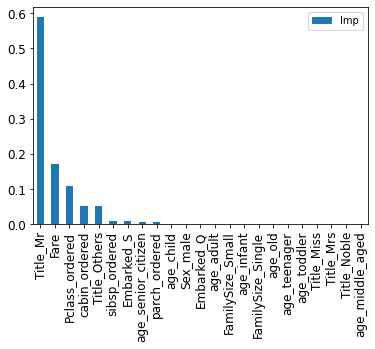

In [137]:
### Plotting the features in descending order of importances
Important.plot(kind='bar')

In [138]:
import os
from graphviz import Source
from IPython.display import SVG
from IPython.display import display
from sklearn.tree import export_graphviz

In [139]:
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'
def plottree(m1):
    labels=train_x.columns
    graph = Source(export_graphviz(m1, out_file=None,feature_names=labels, class_names=['No', 'Yes',] ,filled = True))
    display(SVG(graph.pipe(format='svg')))

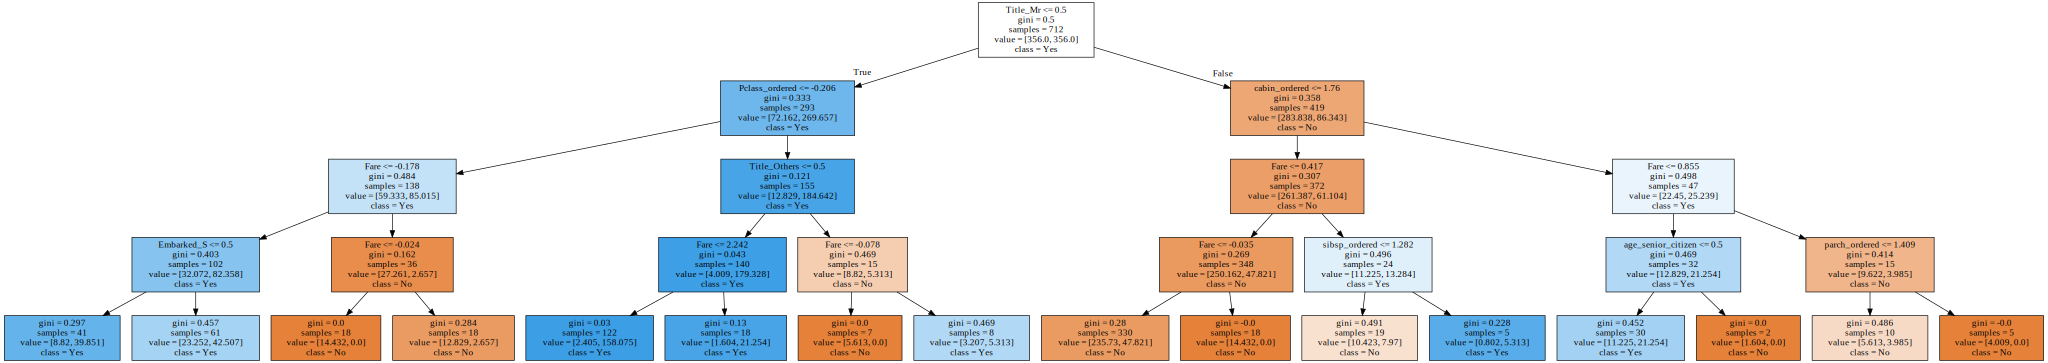

In [140]:
# Visualize the tree
plottree(clf1)

Decision Tree with Grid

In [141]:
# Model Building
from sklearn.model_selection import RandomizedSearchCV
clf_grid=DecisionTreeClassifier(random_state=2,class_weight='balanced')
dt_param_grid = {#"min_samples_leaf": [2,3,4,5,6,7,8,9,10],
              "max_depth": [2,3,4,5,6,7,8,9],
              "criterion":['entropy']}
clf2 = RandomizedSearchCV(clf_grid,dt_param_grid,cv=10,scoring='accuracy',refit='accuracy',n_jobs=-1,n_iter=10000)
# Fitting
%time clf2.fit(train_x,train_y)
print(clf2.best_score_,clf2.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10000. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


CPU times: user 351 ms, sys: 79.4 ms, total: 430 ms
Wall time: 2.49 s
0.8342723004694836 {'max_depth': 3, 'criterion': 'entropy'}


In [142]:
# Predict
train_pred4 = clf2.predict(train_x)
val_pred4 = clf2.predict(val_x)

In [143]:
# Model evaluation
confusion_matrix_train4 = confusion_matrix(train_y, train_pred4)
confusion_matrix_val4 = confusion_matrix(val_y, val_pred4)

Text(0.5, 1.0, 'Grid DT Accuracy Score Train: 0.8384831460674157')

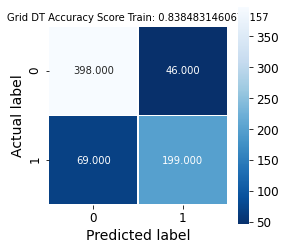

In [144]:
# Confusion matrix for Grid DT Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train4, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Grid DT Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred4)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Grid DT Accuracy Score Train: 0.8044692737430168')

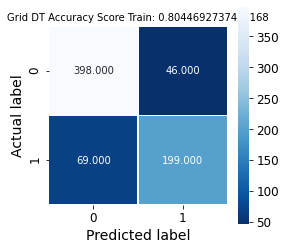

In [145]:
# Confusion matrix for Grid DT Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train4, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Grid DT Accuracy Score Train: {}'.format((accuracy_score(val_y, val_pred4)))
plt.title(all_sample_title, size = 10)

In [146]:
print("Train Accuracy",accuracy_score(train_y,train_pred4))
print("Train Recall",recall_score(train_y,train_pred4, pos_label=1))
print("Train Specificity",recall_score(train_y,train_pred3,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred4))
print("Val Recall",recall_score(val_y, val_pred4, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred4,pos_label=0))

Train Accuracy 0.8384831460674157
Train Recall 0.7425373134328358
Train Specificity 0.8558558558558559
Val Accuracy 0.8044692737430168
Val Recall 0.7432432432432432
Val Specificity 0.8476190476190476


AUC: 0.881


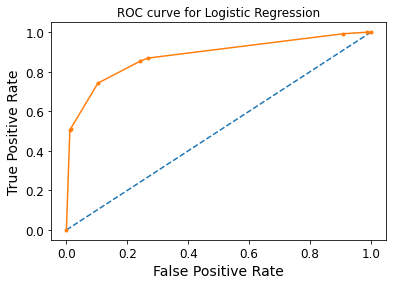

In [147]:
draw_roc_curve(train_x, train_y,clf2)

Random Forest

In [148]:
# Model Building
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(random_state=3,class_weight='balanced')
# Fitting
rf1.fit(train_x,train_y)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [149]:
# Predict
train_pred5 = rf1.predict(train_x)
val_pred5 = rf1.predict(val_x)

In [150]:
# model evaluation
confusion_matrix_train5 = confusion_matrix(train_y, train_pred5)
confusion_matrix_val5 = confusion_matrix(val_y, val_pred5)

Text(0.5, 1.0, 'Random Forest Accuracy Score Train: 0.9592696629213483')

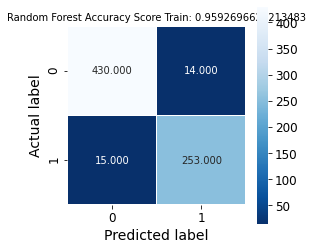

In [151]:
# Confusion matrix for basic Random Forest Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train5, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forest Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred5)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Random Forest Accuracy Score Val: 0.8212290502793296')

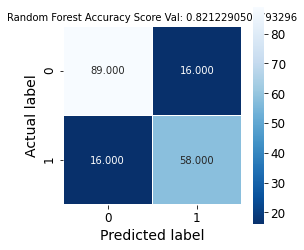

In [152]:
# Confusion matrix for basic Random Forest Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val5, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forest Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred5)))
plt.title(all_sample_title, size = 10)

In [153]:
print("Train Accuracy",accuracy_score(train_y,train_pred5))
print("Train Recall",recall_score(train_y,train_pred5, pos_label=1))
print("Train Specificity",recall_score(train_y,train_pred5,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred5))
print("Val Recall",recall_score(val_y, val_pred5, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred5,pos_label=0))

Train Accuracy 0.9592696629213483
Train Recall 0.9440298507462687
Train Specificity 0.9684684684684685
Val Accuracy 0.8212290502793296
Val Recall 0.7837837837837838
Val Specificity 0.8476190476190476


AUC: 0.990


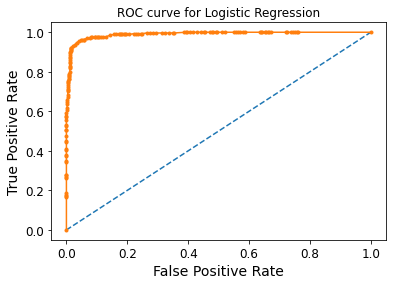

In [154]:
draw_roc_curve(train_x, train_y,rf1)

Random Forest with Grid

In [155]:
# Model Building
from sklearn.ensemble import RandomForestClassifier
rf_grid = RandomForestClassifier(random_state=4,class_weight='balanced')
rf_param_grid = {"n_estimators" : [2,3,4,5,6,7,8,9,10],
                 "max_depth" : [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                 "min_samples_leaf" : [2,3,5,7,10]}
rf2=RandomizedSearchCV(rf_grid,rf_param_grid,cv=10,scoring='accuracy',refit='accuracy',n_jobs=-1)
# Fitting
%time rf2.fit(train_x,train_y)
print(rf2.best_score_,rf2.best_params_)

CPU times: user 377 ms, sys: 7.94 ms, total: 384 ms
Wall time: 904 ms
0.806161971830986 {'n_estimators': 5, 'min_samples_leaf': 3, 'max_depth': 14}


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [156]:
# Predict
pred_train6 = rf2.predict(train_x)
pred_val6 = rf2.predict(val_x)

In [157]:
# model evaluation
confusion_matrix_train6 = confusion_matrix(train_y, pred_train6)
confusion_matrix_val6 = confusion_matrix(val_y, pred_val6)

Text(0.5, 1.0, 'Random Forest Grid Accuracy Score Train: 0.8595505617977528')

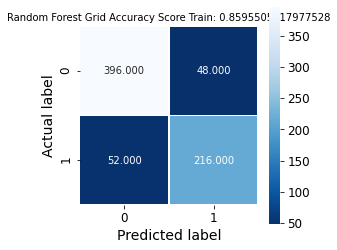

In [158]:
# Confusion matrix for Grid Random Forest Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train6, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forest Grid Accuracy Score Train: {}'.format((accuracy_score(train_y, pred_train6)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Random Forest Grid Accuracy Score Val: 0.8212290502793296')

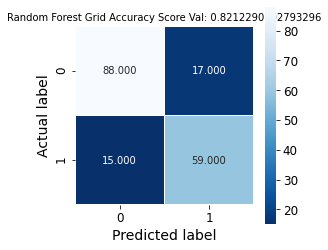

In [159]:
# Confusion matrix for Grid Random Forest Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val6, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forest Grid Accuracy Score Val: {}'.format((accuracy_score(val_y, pred_val6)))
plt.title(all_sample_title, size = 10)

In [160]:
print("Train Accuracy",accuracy_score(train_y,pred_train6))
print("Train Recall",recall_score(train_y, pred_train6, pos_label=1))
print("Train Specificity",recall_score(train_y, pred_train6,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,pred_val6))
print("Val Recall",recall_score(val_y, pred_val6, pos_label=1))
print("Val Specificity",recall_score(val_y, pred_val6,pos_label=0))

Train Accuracy 0.8595505617977528
Train Recall 0.8059701492537313
Train Specificity 0.8918918918918919
Val Accuracy 0.8212290502793296
Val Recall 0.7972972972972973
Val Specificity 0.8380952380952381


Gradient Boosting

In [161]:
# Model Building
from sklearn.ensemble import GradientBoostingClassifier
gbc1=GradientBoostingClassifier(learning_rate=0.001,n_estimators=3000)
# Fitting
%time gbc1.fit(train_x,train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 4.08 s, sys: 1.53 ms, total: 4.08 s
Wall time: 4.08 s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [162]:
# Predict
train_pred7 = gbc1.predict(train_x)
val_pred7 = gbc1.predict(val_x)

In [163]:
# model evaluation
confusion_matrix_train7 = confusion_matrix(train_y, train_pred7)
confusion_matrix_val7 = confusion_matrix(val_y, val_pred7)

Text(0.5, 1.0, 'Gradient Boost Accuracy Score Train: 0.875')

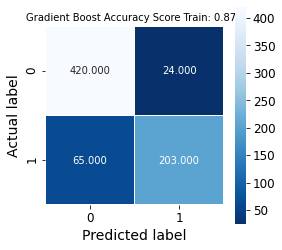

In [164]:
# Confusion matrix for Grid Gradient Boosting Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train7, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Gradient Boost Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred7)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Gradient Boost Accuracy Score Val: 0.8156424581005587')

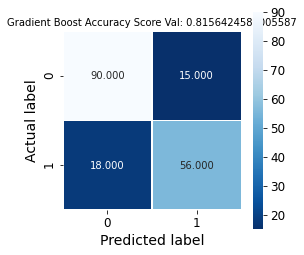

In [165]:
# Confusion matrix for Grid Gradient Boosting Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val7, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Gradient Boost Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred7)))
plt.title(all_sample_title, size = 10)

In [166]:
print("Train Accuracy",accuracy_score(train_y,train_pred7))
print("Train Recall",recall_score(train_y,train_pred7, pos_label=1))
print("Train Specificity",recall_score(train_y,train_pred7,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred7))
print("Val Recall",recall_score(val_y, val_pred7, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred7,pos_label=0))

Train Accuracy 0.875
Train Recall 0.7574626865671642
Train Specificity 0.9459459459459459
Val Accuracy 0.8156424581005587
Val Recall 0.7567567567567568
Val Specificity 0.8571428571428571


AUC: 0.903


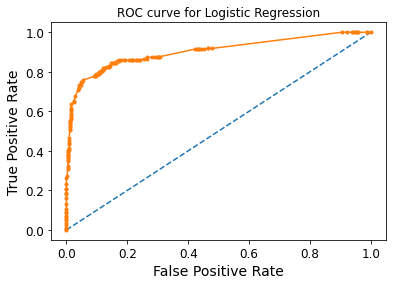

In [167]:
draw_roc_curve(train_x, train_y,gbc1)

Gradient Boosting with Grid

In [168]:
# Model Building
from sklearn.ensemble import GradientBoostingClassifier
gbc_grid=GradientBoostingClassifier(random_state=6)
gbc_param_grid = {"n_estimators" : [2,4,6,8,10],
                  "max_depth" : [3,4,5,6,7,8,9,10,11,12,13,14,15],
                  "min_samples_leaf" : [2,3,5,7,10],
                  "learning_rate": [0.01,0.001,0.001]}
gbc2=RandomizedSearchCV(gbc_grid,gbc_param_grid,cv=10,scoring='recall',refit='recall',n_jobs=-1)
# Fitting
%time gbc2.fit(train_x,train_y)
print(gbc2.best_score_,gbc2.best_params_)

CPU times: user 358 ms, sys: 18.9 ms, total: 377 ms
Wall time: 1.84 s
0.0 {'n_estimators': 2, 'min_samples_leaf': 10, 'max_depth': 9, 'learning_rate': 0.001}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [169]:
# Predict
train_pred8 = gbc2.predict(train_x)
val_pred8 = gbc2.predict(val_x)

In [170]:
# Model evaluation
confusion_matrix_train8 = confusion_matrix(train_y, train_pred8)
confusion_matrix_val8 = confusion_matrix(val_y, val_pred8)

Text(0.5, 1.0, 'Gradient Boost with Grid Accuracy Score Train: 0.6235955056179775')

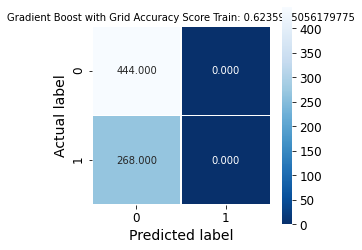

In [171]:
# Confusion matrix for Grid Gradient Boosting Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train8, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Gradient Boost with Grid Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred8)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'Gradient Boost with Grid Accuracy Score Val: 0.5865921787709497')

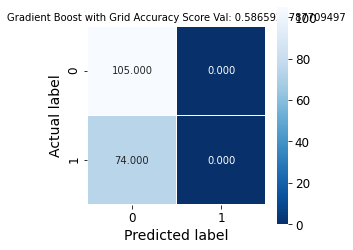

In [172]:
# Confusion matrix for Grid Gradient Boosting Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val8, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Gradient Boost with Grid Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred8)))
plt.title(all_sample_title, size = 10)

In [173]:
print("Train Accuracy",accuracy_score(train_y,train_pred8))
print("Train Recall",recall_score(train_y,train_pred8, pos_label=1))
print("Train Specificity",recall_score(train_y,train_pred8,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred8))
print("Val Recall",recall_score(val_y, val_pred8, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred8,pos_label=0))

Train Accuracy 0.6235955056179775
Train Recall 0.0
Train Specificity 1.0
Val Accuracy 0.5865921787709497
Val Recall 0.0
Val Specificity 1.0


AUC: 0.915


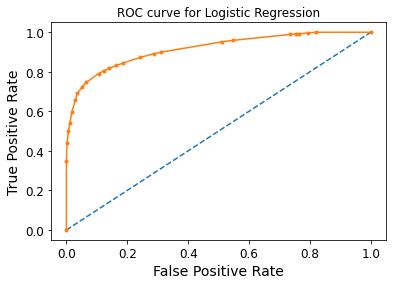

In [174]:
draw_roc_curve(train_x, train_y,gbc2)

Ada Boost

In [175]:
# Model Building
from sklearn.ensemble import AdaBoostClassifier
ab_grid = AdaBoostClassifier(random_state=7)
ab_param_grid = {"n_estimators" : [2,4,6,8,10,20,30],
                 "learning_rate": [0.01,0.001,0.001]}
ab=RandomizedSearchCV(ab_grid,ab_param_grid,cv=10,scoring='accuracy',refit='accuracy',n_jobs=-1,n_iter=10000)

# Fitting
%time ab.fit(train_x, train_y)
print(ab.best_score_,ab.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=10000. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


CPU times: user 511 ms, sys: 14.3 ms, total: 526 ms
Wall time: 3.42 s
0.7738654147104851 {'n_estimators': 2, 'learning_rate': 0.01}


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [176]:
# Predict
train_pred9 = ab.predict(train_x)
val_pred9 = ab.predict(val_x)

In [177]:
# Model evaluation
confusion_matrix_train9 = confusion_matrix(train_y, train_pred9)
confusion_matrix_val9 = confusion_matrix(val_y, val_pred9)

Text(0.5, 1.0, 'XG Boost Accuracy Score Train: 0.7823033707865169')

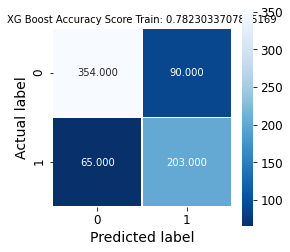

In [178]:
# Confusion matrix for Grid AdaBoost Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train9, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'XG Boost Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred9)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'XG Boost Accuracy Score Val: 0.7821229050279329')

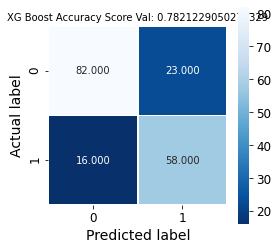

In [179]:
# Confusion matrix for Grid AdaBoost Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val9, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'XG Boost Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred9)))
plt.title(all_sample_title, size = 10)

In [180]:
print("Train Accuracy",accuracy_score(train_y,train_pred9))
print("Train Recall",recall_score(train_y, train_pred9, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred9,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred9))
print("Val Recall",recall_score(val_y, val_pred9, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred9,pos_label=0))

Train Accuracy 0.7823033707865169
Train Recall 0.7574626865671642
Train Specificity 0.7972972972972973
Val Accuracy 0.7821229050279329
Val Recall 0.7837837837837838
Val Specificity 0.780952380952381


AUC: 0.777


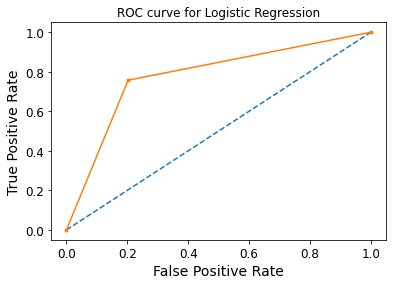

In [181]:
draw_roc_curve(train_x, train_y,ab)

XGB

In [182]:
# Model Building
from xgboost.sklearn import XGBClassifier
xgb_grid = XGBClassifier(random_state=7,class_weight='balanced')
xgb_param_grid = {"n_estimators" : [2,4,6,8,10,15,20],
                 "max_depth" : [2,3,4,5,6,7,8,9,10,12,15],
                 "min_samples_leaf" : [2,3,5,7,10],
                 "learning_rate": 0.001}
xgb1=RandomizedSearchCV(gbc_grid,gbc_param_grid,cv=10,scoring='accuracy',refit='accuracy',n_jobs=-1)
# Fitting
%time xgb1.fit(train_x, train_y)
print(xgb1.best_score_,xgb1.best_params_)

CPU times: user 352 ms, sys: 7.04 ms, total: 359 ms
Wall time: 1.11 s
0.6235915492957746 {'n_estimators': 4, 'min_samples_leaf': 10, 'max_depth': 13, 'learning_rate': 0.001}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [183]:
# Predict
train_pred10 = xgb1.predict(train_x)
val_pred10= xgb1.predict(val_x)

In [184]:
# Model evaluation
confusion_matrix_train10 = confusion_matrix(train_y, train_pred10)
confusion_matrix_val10 = confusion_matrix(val_y, val_pred10)

Text(0.5, 1.0, 'XG Boost Accuracy Score Train: 0.6235955056179775')

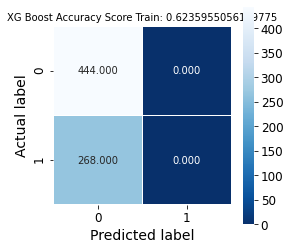

In [185]:
# Confusion matrix for Grid XGBoost Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train10, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'XG Boost Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred10)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'XG Boost Accuracy Score Val: 0.5865921787709497')

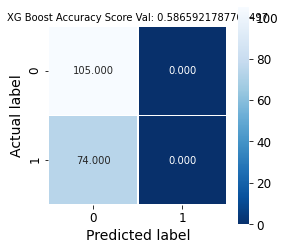

In [186]:
# Confusion matrix for Grid XGBoost Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val10, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'XG Boost Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred10)))
plt.title(all_sample_title, size = 10)

In [187]:
print("Train Accuracy",accuracy_score(train_y, train_pred10))
print("Train Recall",recall_score(train_y, train_pred10, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred10, pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred10))
print("Val Recall",recall_score(val_y, val_pred10, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred10,pos_label=0))

Train Accuracy 0.6235955056179775
Train Recall 0.0
Train Specificity 1.0
Val Accuracy 0.5865921787709497
Val Recall 0.0
Val Specificity 1.0


Stacking Multiple Models to create ensemble models

In [188]:
stacked_pred_train = np.maximum(np.maximum(train_pred1,train_pred3),train_pred10)
stacked_pred_val = np.maximum(np.maximum(val_pred1,val_pred1),val_pred1)
print('---------Stacked Model: MODEL-METRICS-----------')
print('Train Recall Score:{}'.format(recall_score(train_y,stacked_pred_train)))
print('Train Accuracy Score:{}'.format(accuracy_score(train_y,stacked_pred_train)))
print('Val Recall Score:{}'.format(recall_score(val_y,stacked_pred_val)))
print('Val Accuracy Score:{}'.format(accuracy_score(val_y,stacked_pred_val)))

---------Stacked Model: MODEL-METRICS-----------
Train Recall Score:0.832089552238806
Train Accuracy Score:0.8370786516853933
Val Recall Score:0.8108108108108109
Val Accuracy Score:0.8212290502793296


SVM

In [189]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [190]:
# Model Building
from sklearn import svm
svm1= svm.SVC(C=20,kernel='rbf',class_weight='balanced',gamma=0.01)
# Fitting
%time svm1.fit(train_x,train_y)

CPU times: user 33.1 ms, sys: 2.94 ms, total: 36 ms
Wall time: 33.8 ms


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=20, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [191]:
# Predict on train and val
train_pred11 = svm1.predict(train_x)
val_pred11 = svm1.predict(val_x)

In [192]:
# Model evaluation
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_curve,confusion_matrix
confusion_matrix_train11 = confusion_matrix(train_y, train_pred11)
confusion_matrix_val11 = confusion_matrix(val_y, val_pred11)

Text(0.5, 1.0, 'SVM Accuracy Score Train: 0.8469101123595506')

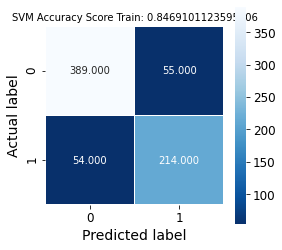

In [193]:
# Confusion matrix for SVM Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train11, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'SVM Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred11)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'SVM Accuracy Score Val: 0.8212290502793296')

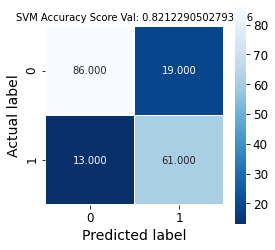

In [194]:
# Confusion matrix for SVM Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val11, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'SVM Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred11)))
plt.title(all_sample_title, size = 10)

In [195]:
print("Train Accuracy",accuracy_score(train_y,train_pred11))
print("Train Recall",recall_score(train_y, train_pred11, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred11,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred11))
print("Val Recall",recall_score(val_y, val_pred11, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred11,pos_label=0))

Train Accuracy 0.8469101123595506
Train Recall 0.7985074626865671
Train Specificity 0.8761261261261262
Val Accuracy 0.8212290502793296
Val Recall 0.8243243243243243
Val Specificity 0.819047619047619


KNN

In [196]:
from sklearn.model_selection import GridSearchCV

def model_building(model, params = None, k = 1) :
    
    if params == None :
        model.fit(train_x, train_y)
        
        # return fitted model & train-test predictions
        return (model, model.predict(train_x), model.predict(val_x))
    
    else :
        model_cv = GridSearchCV(model, param_grid = params, cv = k)
        model_cv.fit(train_x, train_y)
        model = model_cv.best_estimator_
        
        # return and extra object for all cross validation operations
        return (model_cv, model, model.predict(train_x), model.predict(val_x))

In [197]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 7,
                           metric = "euclidean")

model, train_pred12, val_pred12 = model_building(knn)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [198]:
# Model evaluation
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_curve,confusion_matrix
confusion_matrix_train12 = confusion_matrix(train_y, train_pred12)
confusion_matrix_val12 = confusion_matrix(val_y, val_pred12)

Text(0.5, 1.0, 'KNN Accuracy Score Train: 0.851123595505618')

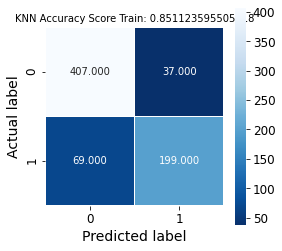

In [199]:
# Confusion matrix for KNN Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train12, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'KNN Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred12)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'KNN Accuracy Score Val: 0.7988826815642458')

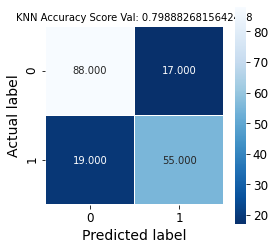

In [200]:
# Confusion matrix for KNN Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val12, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'KNN Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred12)))
plt.title(all_sample_title, size = 10)

In [201]:
print("Train Accuracy",accuracy_score(train_y,train_pred12))
print("Train Recall",recall_score(train_y, train_pred12, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred12,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred12))
print("Val Recall",recall_score(val_y, val_pred12, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred12,pos_label=0))

Train Accuracy 0.851123595505618
Train Recall 0.7425373134328358
Train Specificity 0.9166666666666666
Val Accuracy 0.7988826815642458
Val Recall 0.7432432432432432
Val Specificity 0.8380952380952381


KNN with Grid

In [202]:
params = {"n_neighbors": [2, 5, 9],
          "metric": ["euclidean", "cityblock"]}

knn2 = KNeighborsClassifier(algorithm = "brute", weights = "distance")

model_cv, knn2, train_pred13, val_pred13 = model_building(knn2, params, 10)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

In [203]:
# Model evaluation
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_curve,confusion_matrix
confusion_matrix_train13 = confusion_matrix(train_y, train_pred13)
confusion_matrix_val13 = confusion_matrix(val_y, val_pred13)

Text(0.5, 1.0, 'KNN with Grid Accuracy Score Train: 0.9606741573033708')

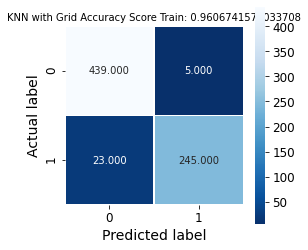

In [204]:
# Confusion matrix for KNN with Grid Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train13, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'KNN with Grid Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred13)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'KNN with Grid Accuracy Score Val: 0.8156424581005587')

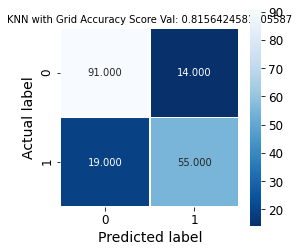

In [205]:
# Confusion matrix for KNN with Grid Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val13, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'KNN with Grid Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred13)))
plt.title(all_sample_title, size = 10)

In [206]:
print("Train Accuracy",accuracy_score(train_y,train_pred13))
print("Train Recall",recall_score(train_y, train_pred13, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred13,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred13))
print("Val Recall",recall_score(val_y, val_pred13, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred13,pos_label=0))

Train Accuracy 0.9606741573033708
Train Recall 0.914179104477612
Train Specificity 0.9887387387387387
Val Accuracy 0.8156424581005587
Val Recall 0.7432432432432432
Val Specificity 0.8666666666666667


Neural Networks

In [208]:
from keras.callbacks import ModelCheckpoint
check=ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5",save_best_only=True,
                      monitor='val_loss',mode='min')
model = Sequential()
model.add(Dense(4, input_shape=(train_x.shape[1],), activation='relu', kernel_initializer='normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_x,train_y,batch_size=100,epochs=70,callbacks=[check], validation_data=(val_x,val_y))


Train on 712 samples, validate on 179 samples
Epoch 1/70
712/712 [==============================] - 0s 679us/sample - loss: 0.6920 - accuracy: 0.5253 - val_loss: 0.6895 - val_accuracy: 0.6760
Epoch 2/70
712/712 [==============================] - 0s 59us/sample - loss: 0.6879 - accuracy: 0.7107 - val_loss: 0.6860 - val_accuracy: 0.6983
Epoch 3/70
712/712 [==============================] - 0s 60us/sample - loss: 0.6829 - accuracy: 0.7416 - val_loss: 0.6797 - val_accuracy: 0.6760
Epoch 4/70
712/712 [==============================] - 0s 63us/sample - loss: 0.6757 - accuracy: 0.7683 - val_loss: 0.6717 - val_accuracy: 0.6983
Epoch 5/70
712/712 [==============================] - 0s 59us/sample - loss: 0.6666 - accuracy: 0.7739 - val_loss: 0.6633 - val_accuracy: 0.7151
Epoch 6/70
712/712 [==============================] - 0s 58us/sample - loss: 0.6578 - accuracy: 0.7725 - val_loss: 0.6549 - val_accuracy: 0.7374
Epoch 7/70
712/712 [==============================] - 0s 56us/sample - loss: 0.6489

Epoch 57/70
712/712 [==============================] - 0s 46us/sample - loss: 0.4222 - accuracy: 0.8118 - val_loss: 0.4480 - val_accuracy: 0.7989
Epoch 58/70
712/712 [==============================] - 0s 40us/sample - loss: 0.4211 - accuracy: 0.8160 - val_loss: 0.4479 - val_accuracy: 0.7989
Epoch 59/70
712/712 [==============================] - 0s 42us/sample - loss: 0.4200 - accuracy: 0.8188 - val_loss: 0.4476 - val_accuracy: 0.8045
Epoch 60/70
712/712 [==============================] - 0s 69us/sample - loss: 0.4193 - accuracy: 0.8188 - val_loss: 0.4471 - val_accuracy: 0.7989
Epoch 61/70
712/712 [==============================] - 0s 68us/sample - loss: 0.4181 - accuracy: 0.8202 - val_loss: 0.4468 - val_accuracy: 0.7989
Epoch 62/70
712/712 [==============================] - 0s 69us/sample - loss: 0.4174 - accuracy: 0.8174 - val_loss: 0.4468 - val_accuracy: 0.7989
Epoch 63/70
712/712 [==============================] - 0s 69us/sample - loss: 0.4167 - accuracy: 0.8174 - val_loss: 0.4466 -

Load the saved best model

In [219]:
import glob
from keras.models import load_model
import tensorflow as tf 
tf.keras.models.load_model
path=os.path.join(os.getcwd(),"*")
list_of_files = glob.glob(path)
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
model = tf.keras.models.load_model(latest_file)

/kaggle/working/weights.66-0.45.hdf5


Making Predictions

In [220]:
# Predict on train and val
train_pred14 = model.predict_classes(train_x)
val_pred14 = model.predict_classes(val_x)

In [221]:
# Model evaluation
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_curve,confusion_matrix
confusion_matrix_train14 = confusion_matrix(train_y, train_pred14)
confusion_matrix_val14 = confusion_matrix(val_y, val_pred14)

Text(0.5, 1.0, 'ANN Accuracy Score Train: 0.8202247191011236')

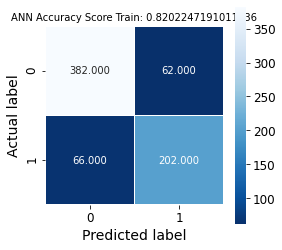

In [222]:
# Confusion matrix for ANN Train
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_train14, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'ANN Accuracy Score Train: {}'.format((accuracy_score(train_y, train_pred14)))
plt.title(all_sample_title, size = 10)

Text(0.5, 1.0, 'ANN Accuracy Score Val: 0.8100558659217877')

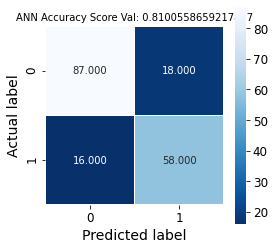

In [223]:
# Confusion matrix for ANN Val
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_val14, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'ANN Accuracy Score Val: {}'.format((accuracy_score(val_y, val_pred14)))
plt.title(all_sample_title, size = 10)

In [224]:
print("Train Accuracy",accuracy_score(train_y,train_pred14))
print("Train Recall",recall_score(train_y, train_pred14, pos_label=1))
print("Train Specificity",recall_score(train_y, train_pred14,pos_label=0))

print("Val Accuracy",accuracy_score(val_y,val_pred14))
print("Val Recall",recall_score(val_y, val_pred14, pos_label=1))
print("Val Specificity",recall_score(val_y, val_pred14,pos_label=0))

Train Accuracy 0.8202247191011236
Train Recall 0.753731343283582
Train Specificity 0.8603603603603603
Val Accuracy 0.8100558659217877
Val Recall 0.7837837837837838
Val Specificity 0.8285714285714286


In [225]:
Target = pd.DataFrame(svm1.predict(test),columns=['Survived'])
pred=pd.concat([PassengerId,Target],axis=1)
pred

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [226]:
pred.PassengerId=pred.PassengerId.astype('int32')

In [227]:
pred.Survived.value_counts()

0    237
1    181
Name: Survived, dtype: int64

In [251]:
pred.to_csv('submission.csv',index=False)